In [2]:
import pandas as pd
import numpy as np
import missingno as mo

# For pre-processing data 
from sklearn import preprocessing as pp 
from sklearn.compose import ColumnTransformer 

# For splits and CV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold # Cross validation 
from sklearn.model_selection import cross_validate # Cross validation 
from sklearn.model_selection import GridSearchCV # Cross validation + param. tuning.

# Machine learning methods 
from sklearn.naive_bayes import GaussianNB as NB
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn import tree # For plotting the decision tree rule

# For evaluating our model's performance
import sklearn.metrics as m

# Pipeline to combine modeling elements
from sklearn.pipeline import Pipeline

#plotting
from plotnine import *
import matplotlib.pyplot as plt

In [17]:
df = pd.read_csv("ML-repression-study/arabbaro/arabbaro_jo_labeled_reduced.csv")

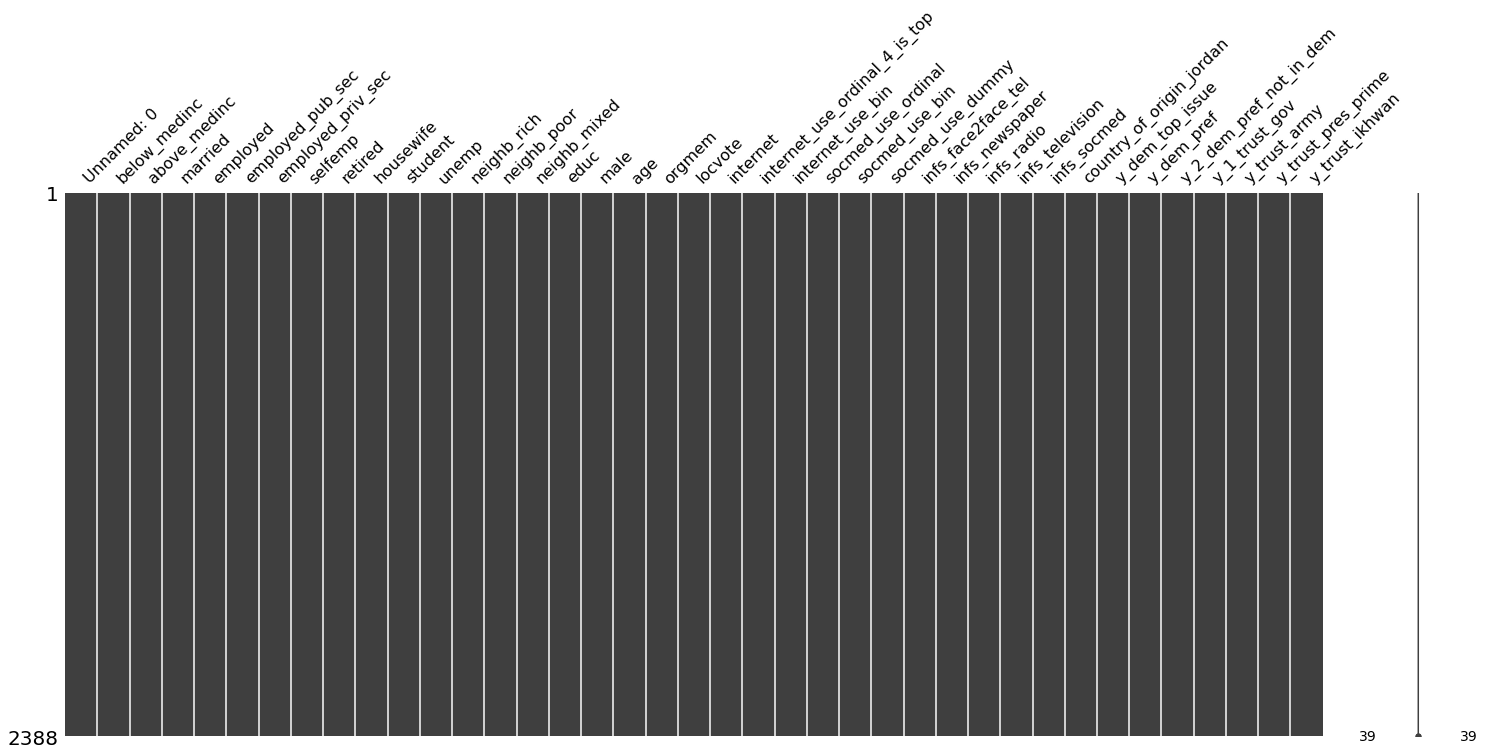

In [18]:
mo.matrix(df)

In [21]:
df.y_1_trust_gov.value_counts()

False    1459
True      929
Name: y_1_trust_gov, dtype: int64

In [29]:
df.y_dem_pref.value_counts()

True     1732
False     656
Name: y_dem_pref, dtype: int64

In [27]:
def create_model(df):
    # set up SKLearn Framework
    y = df.y_dem_pref
    X = df.drop(columns = ["y_dem_top_issue", "y_dem_pref", "y_2_dem_pref_not_in_dem", "y_1_trust_gov", "y_trust_army", "y_trust_pres_prime", "y_trust_ikhwan", "Unnamed: 0"])

    train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=.25,random_state=1234)

    # Set the folds index to ensure comparable samples
    fold_generator = KFold(n_splits=5, shuffle=True,random_state=111)

    # Build the modeling pipeline
    pipe = Pipeline(steps=[('pre_process', pp.MinMaxScaler()),('model',None)])

    search_space = [
    
        # NaiveBayes
        {'model': [NB()]},
    
        # KNN with K tuning param
        {'model' : [KNN()],
        'model__n_neighbors':[5,10,25,50]},
    
        # Decision Tree with the Max Depth Param
        {'model': [DT()],
        'model__max_depth':[2,3,4]},
    
        # Random forest with the N Estimators, max depth, and max features tuning param
        {'model' : [RF()],
        'model__max_depth':[6,7,8],
        'model__n_estimators':[500,1000,1500],
        'model__max_features': [5,10,15]},
    
    ]

    # Grid Search to find the best parameters. The metric used for evaluation is ROC AUC
    search = GridSearchCV(pipe, search_space, 
                         cv = fold_generator,
                         scoring='roc_auc',
                         n_jobs=4)

    # fit the data with the model
    search.fit(train_X,train_y)

    print(search.best_score_)

    print(search.best_params_)

    # Test
    best_mod = search.best_estimator_
    pred_y = search.predict(test_X)
    print(m.roc_auc_score(test_y, pred_y))

    # confusion matrix
    m.plot_confusion_matrix(best_mod, test_X, test_y)

0.5832848335028882
{'model': RandomForestClassifier(max_depth=6, max_features=5, n_estimators=1000), 'model__max_depth': 6, 'model__max_features': 5, 'model__n_estimators': 1000}
0.5049428265645244


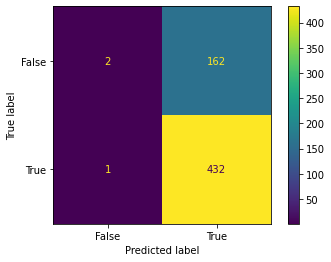

In [28]:
create_model(df)